# Top N Recommendations


In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

Load the data and make sure that all of the empty strings have been filled.

In [2]:
df = pd.read_csv('logdata.csv',dtype=str)
df = df.fillna('None')
df.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,target
0,f10,f20,f30,f40,f50,f60,item0,item0,item1
1,f11,f20,f31,f41,f51,f60,item0,item0,item1
2,f11,f20,f31,f41,f51,f60,item1,item0,item2
3,f11,f20,f31,f41,f51,f60,item2,item1,item3
4,f11,f20,f31,f41,f51,f60,item3,item2,item4


Filter out any target with less than 5 entries

In [3]:
df = df.groupby('target').filter(lambda x: len(x) >= 5)

Build a function to get a dictionary mapper for the factors in the dataframe

In [4]:
def seqtodict(sequence, start=0):
    #transform a sequence to a set of pairs to make into a dictionary
    n = start
    for elem in sequence:
        yield elem,n
        n += 1    

def getItemDict(itemvalues):
    itemvalues = list(itemvalues.unique())
    itemdict = {}
    if 'None' not in itemvalues:
        itemvalues = ['None'] + itemvalues
    itemdict = dict( seqtodict(itemvalues))
    return itemdict

Create a dictionary for each one of the string inputs

In [5]:
itemdict = getItemDict(df['target'])
f1code=getItemDict(df['feature1'])
f2code=getItemDict(df['feature2'])
f3code=getItemDict(df['feature3'])
f4code=getItemDict(df['feature4'])
f5code=getItemDict(df['feature5'])
f6code=getItemDict(df['feature6'])

Map all of the factors to numerical values

In [6]:
def getCodeorNone(x,dictionary):
    output = 0
    try:
        output=dictionary[x]
    except:
        output=dictionary['None']
    return output

df['feature1-code'] = df['feature1'].apply(lambda x: getCodeorNone(x,f1code))
df['feature2-code'] = df['feature2'].apply(lambda x: getCodeorNone(x,f2code))
df['feature3-code'] = df['feature3'].apply(lambda x: getCodeorNone(x,f3code))
df['feature4-code'] = df['feature4'].apply(lambda x: getCodeorNone(x,f4code))
df['feature5-code'] = df['feature5'].apply(lambda x: getCodeorNone(x,f5code))
df['feature6-code'] = df['feature6'].apply(lambda x: getCodeorNone(x,f6code))

df['feature7-code'] = df['feature7'].apply(lambda x: getCodeorNone(x,itemdict))
df['feature8-code'] = df['feature8'].apply(lambda x: getCodeorNone(x,itemdict))
df['target-code'] = df['target'].apply(lambda x: getCodeorNone(x,itemdict))

Create test/train split

In [7]:
train, test = train_test_split(df, test_size=0.2, random_state=23,stratify=df['target-code'])
featurecolumns = ['feature1-code',
              'feature2-code',
              'feature3-code',
              'feature4-code',
              'feature5-code',
              'feature6-code',
              'feature7-code',
              'feature8-code']

features_train = train[featurecolumns].values
labels_train = train['target-code'].values
features_test = test[featurecolumns].values
labels_test = test['target-code'].values

dtrain = xgb.DMatrix(features_train, label=labels_train)
dtest = xgb.DMatrix(features_test, label=labels_test)

In [8]:
# user defined evaluation function, return a pair metric_name, result
# This function takes the top 10 predictions and checks to see if the target label is in that set.
# The error is 1 - the fraction of rows where the label is in the top 10.
def evalerror(preds, dtrain,topNvalue=10):
    labels = dtrain.get_label()
    vals = np.argpartition(preds,-topNvalue)[:,-topNvalue:]
    error = 1 - float(vals.size - np.count_nonzero((vals.transpose() - labels).transpose()))/len(labels)
    # return a pair metric_name, result
    return 'error', error

In [9]:
## Train Model
num_round=30
param = {'max_depth': 5, 
         'booster':dart,
    'eta': 0.2, 
    'silent': 0, 
    'gamma':2,
    'objective':'multi:softprob',
    'num_class':len(np.unique(labels_train))+1,
    'seed':32}
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, dtrain, num_round, watchlist, feval=evalerror, early_stopping_rounds=10)

[0]	eval-merror:0.771175	train-merror:0.759623	eval-error:0.367181	train-error:0.290606
Multiple eval metrics have been passed: 'train-error' will be used for early stopping.

Will train until train-error hasn't improved in 10 rounds.
[1]	eval-merror:0.761348	train-merror:0.741177	eval-error:0.339261	train-error:0.262489
[2]	eval-merror:0.755264	train-merror:0.728776	eval-error:0.32803	train-error:0.249932
[3]	eval-merror:0.753549	train-merror:0.721054	eval-error:0.324286	train-error:0.236517
[4]	eval-merror:0.753393	train-merror:0.714464	eval-error:0.320387	train-error:0.228171
[5]	eval-merror:0.750273	train-merror:0.705183	eval-error:0.314927	train-error:0.221425
[6]	eval-merror:0.748089	train-merror:0.699723	eval-error:0.313836	train-error:0.212261
[7]	eval-merror:0.746373	train-merror:0.693874	eval-error:0.312588	train-error:0.208361
[8]	eval-merror:0.744034	train-merror:0.689818	eval-error:0.31134	train-error:0.203291
[9]	eval-merror:0.743098	train-merror:0.686581	eval-error:0.309

Save the model.

In [10]:
pickle.dump(bst, open("xgb-python.model", "wb"))

Get predictions on the test set and get the "Traditional" accuracy - how likely was the top prediction to match the label.

In [11]:
preds = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
test_labels = dtest.get_label()
test_labels[:10]
toppreds = np.argmax(preds,axis=1)
print("Accuracy: {}".format(accuracy_score(test_labels,toppreds)))

Accuracy: 0.26002183746685387


Check a random sample to double-check the top N prediction error.

In [12]:
print("Testing random entry:")
topNvalue = 10
n = np.random.choice(len(test_labels))
a = preds[n,:]
topN=np.argpartition(preds,-topNvalue)[:,-topNvalue:]
print("Actual: {}".format(test_labels[n]))
print("Top: {}".format(toppreds[n]))
print("Top 10 Predictions: {}".format(topN[n,]))

# Get the accuracy in the top N results
acc=float(topN.size - np.count_nonzero((topN.transpose() - test_labels).transpose()))/len(test_labels)
print("In-sample accuracy: {}".format(acc))   

Testing random entry:
Actual: 145.0
Top: 65
Top 10 Predictions: [  9  65  66 105   3  31   8 128 133  41]
In-sample accuracy: 0.7026984869755108


(0, 1)

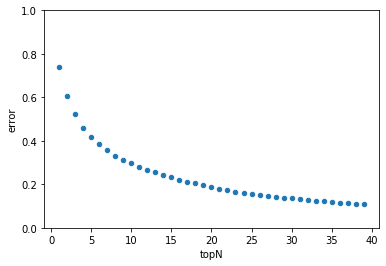

In [13]:
score_eval = pd.DataFrame({'topN':range(1,40)})
score_eval['error'] = score_eval['topN'].apply(lambda x: evalerror(preds,dtest,x)[1])
score_eval.plot(x='topN',y='error',kind='scatter')
plt.ylim(0,1)

Verify that the reload and scoring functions work.

In [14]:
bst2 = pickle.load(open("xgb-python.model", "rb"))
preds2 = bst2.predict(dtest, ntree_limit=bst2.best_ntree_limit)
1-evalerror(preds2,dtest)[1]

0.7026984869755108